### Figure S8

Bar chart with losses per return period per country

In [2]:
import sys
sys.path.append("..") #import folder which is one level higher

import geopandas as gpd
import matplotlib.cbook as cbook
import matplotlib.pyplot as plt
import numpy as np
import os as os
import pandas as pd
import seaborn as sns

from tqdm import tqdm

from utils_functions import load_config
from postproc_functions import *

pd.set_option('max_columns', 100)

In [3]:
### SELECT THE REGIONS FOR WHICH TO LOAD THE RESULTS
pp_out_path = load_config()['paths']['postproc_output']
baseline_results = os.path.join(pp_out_path,'baseline')                              

NUTS0 = NUTS_0_list(EU28=True,EFTA=True,CAND=True) #draw the list of NUTS-0 regions
NUTS0 = [e for e in NUTS0 if e not in ['IS','MT','CY','TR']] #drop Iceland, Malta, Cyprus and Turkey
NUTS3_lst = []
for N0 in NUTS0:
    NUTS3_lst.extend(NUTS_up(N0,True)) #find all the correspondign NUTS-3 regions
regions = [elem for elem in NUTS3_lst if elem not in NUTS_3_remote(Overseas=True,Creta=True,Spain=True)]

### LOAD AND STRUCTURE THE OSM LIGHTING MIX RESULTS WHICH HAVE ALREADY BEEN POSTPROCESSED
df = pd.DataFrame()
exceptions2 = []
for region in tqdm(regions):
    try:
        df = df.append(pd.read_pickle(os.path.join(baseline_results,"{}_EAD_roadtype_litmix.pkl".format(region))))
    except Exception as e:
        exceptions2.append(str(region)+str(e))
        
#for e in exceptions2:
    #print(e)

100%|█████████████████████████████████████████████████████████████████████████████| 1417/1417 [00:03<00:00, 429.38it/s]


In [ ]:
exceptions2

In [4]:
df1 = df.copy()
df1.head()

""


In [7]:
df1['NUTS-0'] = df1['NUTS-3'].map(lambda x: NUTS_down(NUTS_down(NUTS_down(x)))) #derive country codes from NUTS-3 names
#df2 = df1.groupby('NUTS-0').sum() #sum by country
df1 = df1.reset_index()
df1['EAD_litmix_avg'] = df1[['EAD_lowflow', 'EAD_highflow']].mean(axis=1) #take the average of lowflow and highflow for litmix
df1 = df1.drop(columns=['EAD_HZ','EAD_lowflow','EAD_highflow','NUTS-3'])
df1.head(n=10)

,road_type,NUTS-0,EAD_litmix_avg
0,other,AL,767.734007
1,secondary,AL,7174.488352
2,tertiary,AL,229.445880
3,track,AL,112.809963
4,none,AL,0.000000
5,other,AL,20963.875993
6,primary,AL,7347.173333
7,secondary,AL,12834.900674
8,tertiary,AL,8097.203146
9,track,AL,4861.367116


In [8]:
df2 = df1.groupby(by=['NUTS-0','road_type']).sum() #returns a multi-index
df2 = df2.unstack() #unstack the multi-index
df2.columns = df2.columns.droplevel() #drop the nasty multilevel column index
df2.drop(columns=['none','track'],inplace=True) #drop unused road types
order = ['motorway','trunk','primary','secondary','tertiary','other'] #reorder the columns for nice plotitng
df2 = df2.reindex(columns=order)
df2.columns = ['Motorway','Trunk','Primary','Secondary','Tertiary','Other'] #Including capitals

In [9]:
df2['total'] = df2.sum(axis=1) #calculate the sum to order
df2.sort_values(by='total',axis=0,ascending=False,inplace=True)
print("Checksum: all damage is: {} mln euro per year".format(df2['total'].sum()*10**(-6)))
df2.drop(columns=['total'],inplace=True) #remove the total column again

Checksum: all damage is: 230.50773807982335 mln euro per year


In [10]:
df3 = df2[df2.columns[::-1]] #reverse the order of the columns
df3 = df3*10**(-6)

In [11]:
#set figure settings:
brew_1 =  ['#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026']

Text(0, 0.5, 'Expected annual damage in million Euro per year')

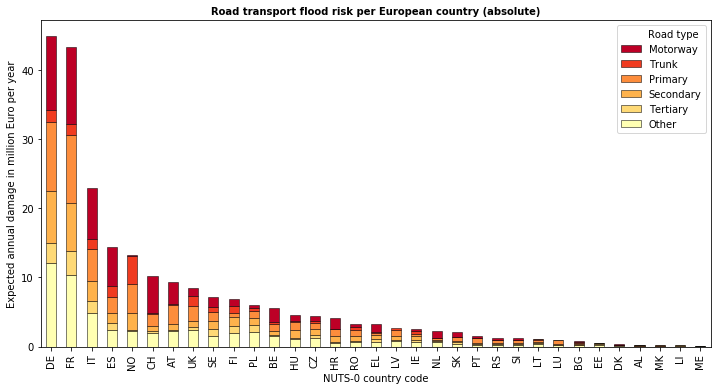

In [12]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
df3.plot(kind='bar',stacked=True,ax=ax,color=brew_1,linewidth=0.5,edgecolor='black')
fs = 10 #fontsize

handles_2, labels_2 = ax.get_legend_handles_labels() 
ax.legend(handles_2[::-1], labels_2[::-1],title='        Road type') #inverse the order of the labels

ax.set_title('Road transport flood risk per European country (absolute)', fontsize=fs, fontweight='bold')
ax.set_xlabel('NUTS-0 country code', fontsize=fs)
ax.set_ylabel('Expected annual damage in million Euro per year', fontsize=fs)

#plt.savefig("Paper_Figure_SI_3A_EAD_per_country.png", dpi=200, bbox_inches="tight")

In [15]:
df3.loc['NL'].sum()

2.2629489109111454

In [213]:
#RELATIVE

In [221]:
df4 = df3.apply(lambda x: 100 * x/x.sum(axis=0), axis=1)

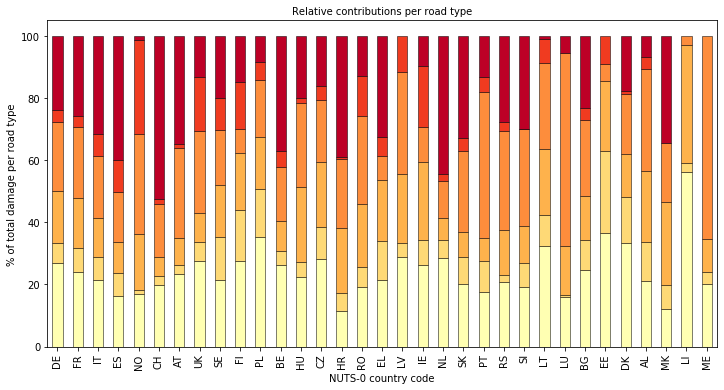

In [228]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
df4.plot(kind='bar',stacked=True,ax=ax,color=brew_1,linewidth=0.5,edgecolor='black')
fs = 10 #fontsize

#handles_2, labels_2 = ax.get_legend_handles_labels() 
#ax.legend(handles_2[::-1], labels_2[::-1],title='        Road type') #inverse the order of the labels
ax.get_legend().remove()

ax.set_title('Relative contributions per road type', fontsize=fs)
ax.set_xlabel('NUTS-0 country code', fontsize=fs)
ax.set_ylabel('% of total damage per road type', fontsize=fs)

plt.savefig("Paper_Figure_SI_3B_EAD_per_country.png", dpi=200, bbox_inches="tight")